In [2]:
import os

# Define the paths for 'normal' and 'anomaly' folders
datasets_folder_path = '/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/'


normal_folder_path = os.path.join(datasets_folder_path, 'good')
anomaly_folder_path = os.path.join(datasets_folder_path, 'ng')

# Get the list of image files in each folder
normal_images = [f for f in os.listdir(normal_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
anomaly_images = [f for f in os.listdir(anomaly_folder_path) if f.endswith('.jpg') or f.endswith('.png')]


In [3]:
from PIL import Image

# Check the number of images in each folder
num_normal_images = len(normal_images)
num_anomaly_images = len(anomaly_images)

# Load a few sample images to check dimensions and color distribution
sample_normal_image = Image.open(os.path.join(normal_folder_path, normal_images[0]))
sample_anomaly_image = Image.open(os.path.join(anomaly_folder_path, anomaly_images[0]))

sample_normal_image.size, sample_anomaly_image.size


((1024, 1024), (1024, 1024))

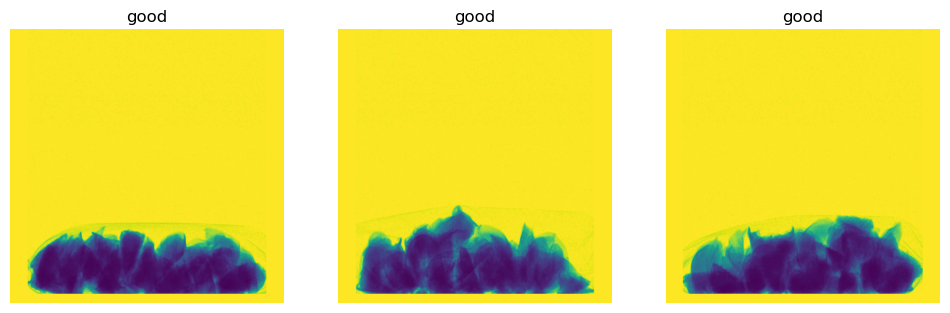

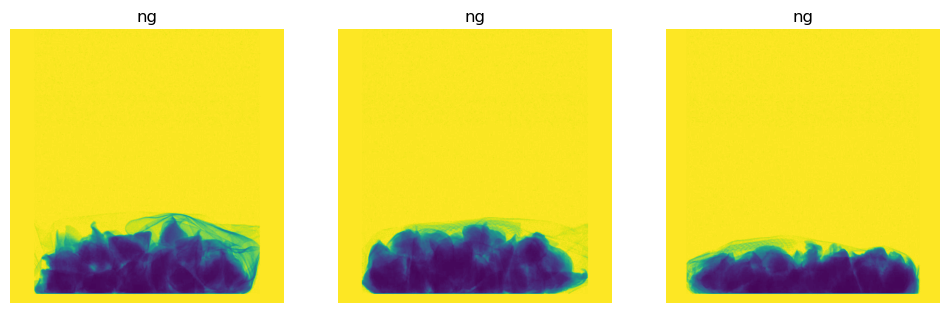

In [4]:
#이미지 확인

import matplotlib.pyplot as plt

# Load a few sample images from 'normal' and 'anomaly'
sample_normal_images = [Image.open(os.path.join(normal_folder_path, img)) for img in normal_images[:3]]
sample_anomaly_images = [Image.open(os.path.join(anomaly_folder_path, img)) for img in anomaly_images[:3]]

# Plot sample images from 'normal' folder
plt.figure(figsize=(12, 4))
for i, img in enumerate(sample_normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('good')
    plt.axis('off')
plt.show()

# Plot sample images from 'anomaly' folder
plt.figure(figsize=(12, 4))
for i, img in enumerate(sample_anomaly_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title('ng')
    plt.axis('off')
plt.show()


In [7]:
#이미지 리사이징

from PIL import Image

# Function to resize image to make it close to 1MB
def resize_image(image_path, output_path):
    with Image.open(image_path) as img:
        img = img.resize((512, 512))  # Example dimension, you may need to adjust this
        img.save(output_path)

# Resize a sample image to check the new file size
resize_image(os.path.join(normal_folder_path, normal_images[0]), '/Users/kimsy/DataScience/dataset/fm_img/horizontal/train/resized_output/sample_resized.jpg')


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0)
train_gen = datagen.flow_from_directory(datasets_folder_path, 
                                        classes=['good', 'normal'], 
                                        batch_size=32, 
                                        target_size=(512, 512), 
                                        class_mode='binary')


Found 87 images belonging to 2 classes.


In [14]:
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import MobileNetV2

# base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [21]:
from fastai.vision import *
from fastai.metrics import accuracy
from pathlib import Path

# Define the path to the dataset folder
path = Path(datasets_folder_path)

# Create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the type of data
    get_items=get_image_files,  # Function to get a list of image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 20% validation set
    get_y=parent_label,  # Label based on the parent folder
    item_tfms=Resize(512),  # Resize images to 512x512
    batch_tfms=aug_transforms()  # Additional data augmentation
)

# Create a databunch with batch size 32
dls = dblock.dataloaders(path, bs=32)

# Create a learner with the datablock, using a mobilenet_v2 architecture
learn = cnn_learner(dls, models.mobilenet_v2, metrics=accuracy)


NameError: name 'DataBlock' is not defined